**Из каких файлов состоит data/RuMedTop3:**

train_v1.jsonl — обучающая выборка (4690 записей). 105 различных диагнозов

dev_v1.jsonl — валидация (848 записей)

test_v1.jsonl — тест (6 360 записей)

***symptoms*** — входной текст

Это сырой клинический текст на русском, написанный врачами:

*   короткие заметки или абзацы из истории болезни
*   много аббревиатур: «АД», «ФН», «ЧСС», «Т°» и т.п.
*   встречаются описки, разговорные фразы, обрывки предложений
*   упоминаются жалобы, анамнез, локализация боли, длительность и т.д

***code*** — целевой диагноз


*   Это ICD-10 код, урезанный до 2-го уровня (пример: M54, I10, J06 и т.п.)
*   Всего 105 классов (в train)
*   Редкие диагнозы с частотой <10 выброшены при подготовке



**Происхождение данных:**

RuMedTop3 построен на основе более крупного клинического корпуса RuMedPrime:

1.	Взяты реальные истории болезни из RuMedPrime.

2.	Из них выделено текстовое поле с симптомами/жалобами → symptoms.

3.	К каждому примеру привязан код диагноза по МКБ-10 → code.

4.	Коды приведены к 2-му уровню МКБ-10.

5.	Убраны:
o	слишком редкие диагнозы (малое число наблюдений),
o	записи с пустым или некорректным текстом.

6.	Полученные записи разбиты на три файла: train / dev / test.


При этом данные анонимизированы: персональные данные, ФИО, номера карт и т.п. удалены или обезличены.


In [ ]:
import pandas as pd


train_path = "/content/sample_data/train_v1.jsonl"
dev_path   = "/content/sample_data/dev_v1.jsonl"
test_path  = "/content/sample_data/test_v1.jsonl"

train = pd.read_json(train_path, lines=True)
dev   = pd.read_json(dev_path,   lines=True)
test  = pd.read_json(test_path,  lines=True)

train.head()

,idx,symptoms,code
0,q43dfecc,Жалобы на болит во всех суставах но более в кр...,M17
1,qc371011,На боли в правом плече с иррадиацией в локтево...,M53
2,q5bcb667,"боль в эпигастрии после погрешности в диете, в...",K29
3,q820c321,"боль в правом плечевом суставе, в правом плече...",M54
4,q0c7a1fb,- приливы пота в только на улице - снижение ве...,E27


Всего уникальных диагнозов: 105


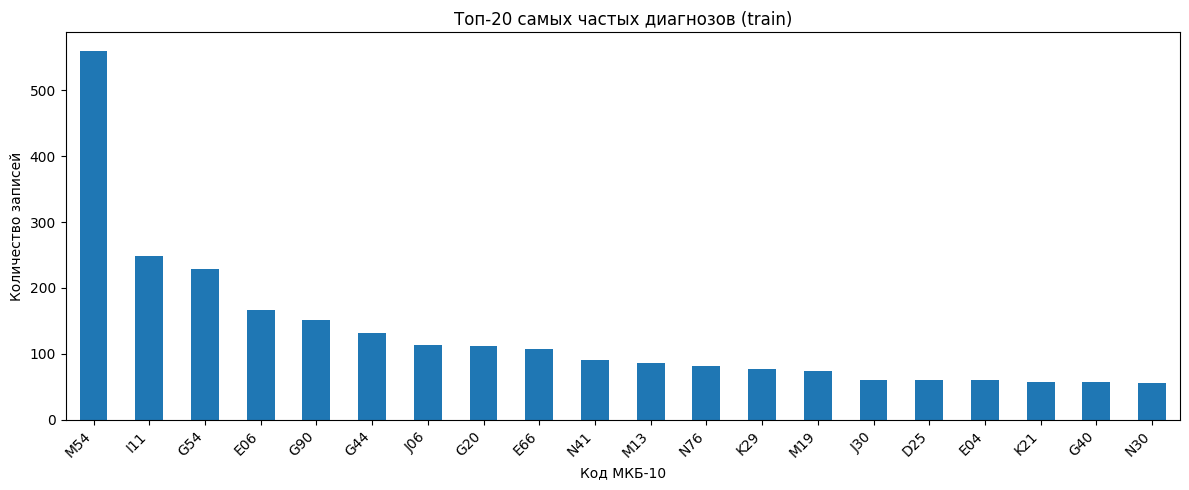

In [ ]:
import matplotlib.pyplot as plt

code_counts = train["code"].value_counts()

print("Всего уникальных диагнозов:", code_counts.shape[0])

top_n = 20
top_codes = code_counts.head(top_n)

plt.figure(figsize=(12, 5))
top_codes.plot(kind="bar")
plt.title(f"Топ-{top_n} самых частых диагнозов (train)")
plt.xlabel("Код МКБ-10")
plt.ylabel("Количество записей")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


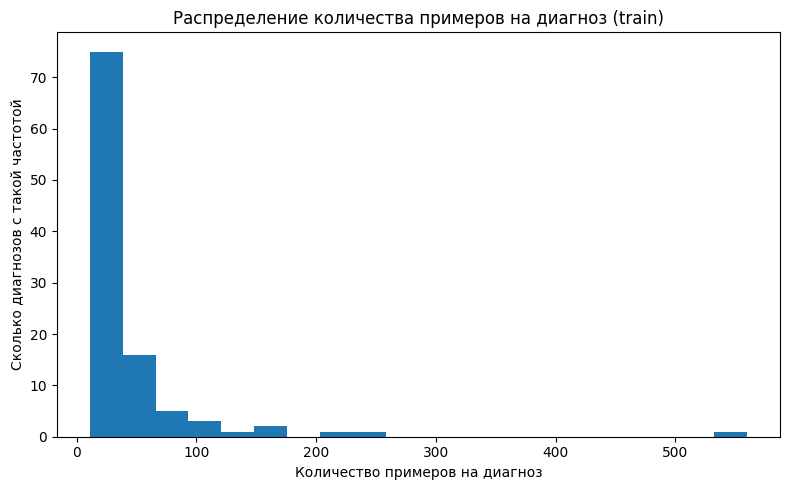

Мин. примеров на диагноз: 11
Макс. примеров на диагноз: 560
Среднее примеров на диагноз: 44.666666666666664


In [ ]:
freq_per_class = code_counts.values  # массив: [частота_класса_1, ..., частота_класса_N]

plt.figure(figsize=(8, 5))
plt.hist(freq_per_class, bins=20)
plt.title("Распределение количества примеров на диагноз (train)")
plt.xlabel("Количество примеров на диагноз")
plt.ylabel("Сколько диагнозов с такой частотой")
plt.tight_layout()
plt.show()

print("Мин. примеров на диагноз:", freq_per_class.min())
print("Макс. примеров на диагноз:", freq_per_class.max())
print("Среднее примеров на диагноз:", freq_per_class.mean())


**Выводы:**

•	Long tail: есть хвост из довольно редких кодов, на которых модель будет страдать без трюков (re-weighting, focal loss, oversampling)

•	Метрика Hit@3 специально выбрана, чтобы снизить штраф за этот дисбаланс: врачу достаточно получить несколько кандидатов


In [ ]:
# самый частый диагноз
most_common_code = code_counts.idxmax()
print("Самый частый диагноз:", most_common_code, "—", code_counts.max(), "примеров")

print("\nПримеры записей для самого частого диагноза:\n")
examples_common = train[train["code"] == most_common_code]["symptoms"].head(3).tolist()
for i, ex in enumerate(examples_common, 1):
    print(f"пример {i}:")
    print(ex)
    print()

# один из наименее частых диагнозов (но всё же в выборке)
least_common_code = code_counts.index[-1]
print("Один из самых редких диагнозов:", least_common_code, "—", code_counts.iloc[-1], "примеров")

print("\nПримеры записей для редкого диагноза:\n")
examples_rare = train[train["code"] == least_common_code]["symptoms"].head(3).tolist()
for i, ex in enumerate(examples_rare, 1):
    print(f"пример {i}:")
    print(ex)
    print()


Самый частый диагноз: M54 — 560 примеров

Примеры записей для самого частого диагноза:

пример 1:
боль в правом плечевом суставе, в правом плече, с иррад в кисть, подергивание и онемение в правой руке. Болевой синдром на фоне терапии (каликсат, катэна) менее выражен, увеличен объем движений в правом плечевом суставе.

пример 2:
На боли в шейном отделе позвоночника с иррадиацией в голову, боль в пояснице.

пример 3:
боль в области левой лопатки, в межлопаточной области, усиливается при сидении, при занятияз спортом.

Один из самых редких диагнозов: H65 — 11 примеров

Примеры записей для редкого диагноза:

пример 1:
на заложенность левого уха и боль вт нем

пример 2:
На заложенность уха слева, повышение темп до 37.0, заложенность носа

пример 3:
Боль в правом ухе. Температура, стул, диурез в норме

